In [1]:
import numpy as np
import copy
from scipy.optimize import linear_sum_assignment
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from keras.models import model_from_json

import keras
import pickle

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Create Conv-2 architectures

In [2]:
def conv2_cnn(initializer = tf.initializers.GlorotNormal()):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.

    Conv-2 architecture-
    64, 64, pool  -- convolutions
    256, 256, 10  -- fully connected layers
    
    Inputs:
    'initializer' defines which initializer to use for weights and biases
    'custom' is True if model should follow the custom fit-function and not train weights that are 0

    Output: Returns designed and compiled neural network model
    """
    # no need for custom model, if we do not train models
    model = Sequential()
    
    # first conv layer
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = initializer,
            bias_initializer = initializer,
            strides = (1, 1), padding = 'same',
            input_shape=(32,32, 3)
            )
    )

    # second conv layer
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = initializer,
            bias_initializer = initializer,
            strides = (1, 1), padding = 'same'
            )
    )
    
    # pooling layer
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )

    model.add(Flatten())
    
    # first dense layer
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = initializer,
            bias_initializer = initializer
        )
    )

    # second dense layer
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = initializer,
            bias_initializer = initializer
        )
    )

    # third dense layer / output layer
    model.add(
        Dense(
            units = 10, activation='softmax'
        )
    )


    # Compile CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
        metrics=['accuracy']
    )


    return model

## SaSD to compare conv1-layer

In [3]:
def getWeightsArray(mod):
    weights = []
    for layer in mod.layers:
        if isinstance(layer, keras.layers.core.Dense) or isinstance(layer, keras.layers.convolutional.Conv2D):
            weights.append(np.array(layer.get_weights()[0])) 
            
    return weights

# gets two vectors with all weights (! and not just the connection indices) and gives back edit distance
def editDistanceSigns(a,b):
    nums = len(a) - len(np.intersect1d(np.where(b==0), np.where(a==0)))
    same = len(np.intersect1d(np.where(a<0), np.where(b<0))) + len(np.intersect1d(np.where(a>0), np.where(b>0)))
    if nums == 0:
        return 0
    return (nums-same)/nums

def compareLayers(layer1, layer2):
    
    assert layer1.shape == layer2.shape

    # k is nr of kernels/neurons
    k = layer1.shape[-1]

    #print(layer1.shape)
    bottomList1 = [] 
    bottomList2 = []
    
    # if conv layer, shape has length 4 (height, width, channels, kernels)
    if len(layer1.shape) == 4:
      
        for kernel in range(k):
            bottomList1.append(layer1[:,:,:, kernel].flatten())

        for kernel in range(k):
            bottomList2.append(layer2[:,:,:, kernel].flatten())

    # a dense layer, shape is (neurons last layer, neurons this layer)
    else:
        for j in range(layer1.shape[1]):
            bottomList1.append(layer1[:, j])

        for j in range(layer2.shape[1]):
            bottomList2.append(layer2[:, j])

        # if last layer (output layer has 10 neurons):
        if layer1.shape[1] == 10:
            # do just compute distance, without being able to change order of output neurons
            summed_dist = 0
            for j in range(10):
                summed_dist += editDistanceSigns(bottomList1[j], bottomList2[j])
            return summed_dist/10, range(10), range(10)     

    editMatrix = np.zeros((k, k))
    for j1 in range(k):
        for j2 in range(k):
            editMatrix[j1, j2] = editDistanceSigns(bottomList1[j1], bottomList2[j2])

    row_ind, col_ind = linear_sum_assignment(editMatrix)
    minCost = editMatrix[row_ind, col_ind].sum()

    return minCost / k

## Extract saved Models

In [4]:
# function to get CNN from json and h5 files
def getModelFromFile(json_file, h5_file):
    # get model structure from json
    json = open(json_file, "r")
    loaded_json = json.read()
    json.close()
    model = model_from_json(loaded_json)
    
    # load weights in model
    model.load_weights(h5_file)
    return model

In [5]:
def is_WT(his_WT, his_orig):
    return (np.argmin(his_WT["val_loss"])<=np.argmin(his_orig["val_loss"])) and (np.min(his_WT["val_loss"])<1.02*np.min(his_orig["val_loss"]))

In [6]:
# array with WTs and with random tickets
WTs_CIFAR = []
WTs_CINIC = []
WTs_SVHN = []
randoms = []

# for each possible WT for CIFAR, add to array if it is one
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_CIFAR/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_CIFAR/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_CIFAR.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_CIFAR/WT_s0.1_nr" + str(i) + ".h5"))

#CINIC
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_CINIC/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_CINIC/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_CINIC.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_CINIC/WT_s0.1_nr" + str(i) + ".h5"))
        
#SVHN
for i in range(0, 20):
    # extract history
    his_orig = pickle.load(open('../tickets/WTs_SVHN/his_orig_s0.1_nr' + str(i), "rb"))
    his_WT = pickle.load(open('../tickets/WTs_SVHN/his_WT_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if is_WT(his_WT, his_orig):
        WTs_SVHN.append(getModelFromFile("../tickets/conv2.json", "../tickets/WTs_SVHN/WT_s0.1_nr" + str(i) + ".h5"))
        
        
# for each random ticket, add to array if it is not a WT
for i in range(0,20):
    # extract history
    his_orig = pickle.load(open('../tickets/random/his_orig_s0.1_nr' + str(i), "rb"))
    his_random = pickle.load(open('../tickets/random/his_random_s0.1_nr' + str(i), "rb"))
    # check if it is a WT (min epoch same or equal, min val_loss smaller or only 2%(?) higher)
    if not is_WT(his_random, his_orig):
        randoms.append(getModelFromFile("../tickets/conv2.json", "../tickets/random/random_s0.1_nr" + str(i) + ".h5"))
        
# take same amount of subnetworks for each condition (minimum of WTs of each type, in my case 14)  
min_len = min(len(randoms), len(WTs_SVHN), len(WTs_CIFAR), len(WTs_CINIC))

randoms = randoms[:min_len]
WTs_SVHN = WTs_SVHN[:min_len]
WTs_CIFAR = WTs_CIFAR[:min_len]
WTs_CINIC = WTs_CINIC[:min_len]

## Main

### Get comparison values, distances of conv1-layers between SVHN and all other groups

In [7]:
dists_WTs_SVHN = []
for i,ticket in enumerate(WTs_SVHN):
    for j,ticket2 in enumerate(WTs_SVHN):
        if i <j:
            dists_WTs_SVHN.append(compareLayers(ticket.layers[0].get_weights()[0], ticket2.layers[0].get_weights()[0]))
            
print("mean dists WTs_SVHN", np.mean(dists_WTs_SVHN))
mean_dist_WTs_SVHN = np.mean(dists_WTs_SVHN)


dists_mixed_SVHN = []
for i,ticket in enumerate(WTs_SVHN):
    for j,ticket2 in enumerate(randoms):
        dists_mixed_SVHN.append(compareLayers(ticket.layers[0].get_weights()[0], ticket2.layers[0].get_weights()[0]))
            
print("mean dists mixed_SVHN", np.mean(dists_mixed_SVHN))
mean_dist_mixed_SVHN = np.mean(dists_mixed_SVHN)


dists_between_SVHN_CIFAR = []
for i,ticket in enumerate(WTs_SVHN):
    for j,ticket2 in enumerate(WTs_CIFAR):
        dists_between_SVHN_CIFAR.append(compareLayers(ticket.layers[0].get_weights()[0], ticket2.layers[0].get_weights()[0]))
            
print("mean dists between_SVHN_CIFAR", np.mean(dists_between_SVHN_CIFAR))
mean_dist_between_SVHN_CIFAR = np.mean(dists_between_SVHN_CIFAR)


dists_between_SVHN_CINIC = []
for i,ticket in enumerate(WTs_SVHN):
    for j,ticket2 in enumerate(WTs_CINIC):
        dists_between_SVHN_CINIC.append(compareLayers(ticket.layers[0].get_weights()[0], ticket2.layers[0].get_weights()[0]))
            
print("mean dists between_SVHN_CINIC", np.mean(dists_between_SVHN_CINIC))
mean_dist_between_SVHN_CINIC = np.mean(dists_between_SVHN_CINIC)

mean dists WTs_SVHN 0.619618959950443
mean dists mixed_SVHN 0.7216130194796959
mean dists between_SVHN_CIFAR 0.674226309961663
mean dists between_SVHN_CINIC 0.6845878851266365


### Higher standard deviation of nr of weights per filter

In [8]:
# prune to std of 2.35 (random) up to 3.45 (SVHN)

def prune_conv2_higher_std(model, std):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'std' is the standard deviation whcih should be achieved in layer conv1 concerning how many
    weights are left per kernel
    
    Returns:
    pruned_model 
    '''

    ### initialize new model with 0 everywhere that's going to get changed
    pruned_model = conv2_cnn("zeros")  
    
    # only prune first layer
                        
    # shape of w is (height, width, channels, filter), shape of b is (tensors)
    w = model.layers[0].get_weights()[0]
    b = model.layers[0].get_weights()[1] # doesn't need to be changed

    # for each filter seperately: leave x nr of weights, coming from a normal distribution with
    # mean 8.5 and std 2.35 (random) up to 3.45 (SVHN)
    w_new = np.zeros((3,3,3,64))
    for nr in range(64):
        # draw from distribution and get percentage of left weights (divide by nr of all weights, 27)
        # substract from 1 to get percentage to be pruned
        pruned_weights_perc = (1 - np.random.normal(8.469, std)/27) * 100
        
        # if it is over 100% (should not occure often), cut to 100:
        if pruned_weights_perc > 100:
            pruned_weights_perc = 100
                        
        # f is filter at pos "nr"
        f = w[:,:,:,nr]
        
        # Compute absolute value of whole filter
        f_abs = np.abs(f)

        # Mask values to zero which are less than 'p' in terms of magnitude
        f_abs[f_abs < np.percentile(f_abs, pruned_weights_perc)] = 0

        # Where 'f_abs' equals 0, keep 0, else, replace with values of 'f'
        w_new[:,:,:,nr] = np.where(f_abs == 0,0,f)


    pruned_model.layers[0].set_weights([w_new,b])

        

    return pruned_model

In [9]:
# special prune randomly-initialized networks
# let std go from 2.35 to 3.45 in steps of 0.1
nr_networks_per_std = 5

# save means and corresponding stds for plotting
stds = []
dists_all = []

for std in np.arange(2.35, 3.65, 0.1):
    for n in range(nr_networks_per_std):

        net = conv2_cnn()
        net_pruned = prune_conv2_higher_std(net, round(std,2))
        
        # get actual std of net
        weights_per_kernel = []
        for f in range(64):
            weights_per_kernel.append(np.sum(np.array(net_pruned.layers[0].get_weights()[0])[:,:,:,f]!= 0))
        
        stds.append(np.std(weights_per_kernel))

        dists = []
        
        # compare to WTs, only first layer        
        for i,ticket in enumerate(WTs_SVHN):
            dists.append(compareLayers(ticket.layers[0].get_weights()[0], net_pruned.layers[0].get_weights()[0]))
            
        dists_all.append(np.mean(dists))

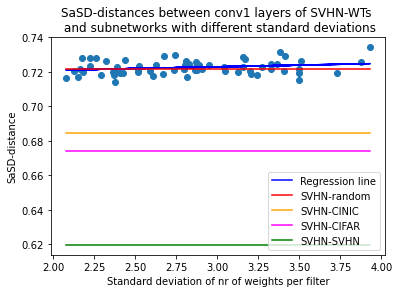

In [10]:
# plot dists_all comparing to other results as baselines:
plt.scatter(stds, dists_all)

#add linear regression line to scatterplot 
m, b = np.polyfit(stds, dists_all, 1)
plt.plot(stds, m*np.array(stds)+b, color = "blue", label = "Regression line")

plt.plot([min(stds), max(stds)], [mean_dist_mixed_SVHN, mean_dist_mixed_SVHN],color='red', label = "SVHN-random")
plt.plot([min(stds), max(stds)], [mean_dist_between_SVHN_CINIC, mean_dist_between_SVHN_CINIC],color='orange', label = "SVHN-CINIC")
plt.plot([min(stds), max(stds)], [mean_dist_between_SVHN_CIFAR, mean_dist_between_SVHN_CIFAR],color='magenta', label = "SVHN-CIFAR") 
plt.plot([min(stds), max(stds)], [mean_dist_WTs_SVHN, mean_dist_WTs_SVHN],color='green', label = "SVHN-SVHN")

plt.title("SaSD-distances between conv1 layers of SVHN-WTs \n and subnetworks with different standard deviations")
plt.ylabel("SaSD-distance")
plt.xlabel("Standard deviation of nr of weights per filter")
plt.legend(loc = "lower right")
plt.show()

In [11]:
x = stds.copy()
y = dists_all.copy()
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.499
Date:                Fri, 18 Feb 2022   Prob (F-statistic):             0.0661
Time:                        23:49:15   Log-Likelihood:                 267.88
No. Observations:                  65   AIC:                            -531.8
Df Residuals:                      63   BIC:                            -527.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7170      0.003    237.009      0.0

### Higher percentage of positive weights

In [12]:
# need to prune 68.619 percent of weights, varying ratio of positive to negative weights

def prune_conv2_higher_ratio(model, ratio):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'ratio' is the ratio of positive to negative weights
    
    Returns:
    pruned_model 
    '''

    ### initialize new model with 0 everywhere that's going to get changed
    pruned_model = conv2_cnn("zeros")  
    
    # only prune first layer
                        
    # shape of w is (height, width, channels, filter), shape of b is (tensors)
    w = model.layers[0].get_weights()[0]
    b = model.layers[0].get_weights()[1] # doesn't need to be changed

    pruned_weights_perc = 68.619
    
    # take different pruned_weights_percentages for positive and negative weights, such that 
    # the ratio of left_weights_positive / left_weights_negative = ratio
    left_weights_neg_percentage = (100-pruned_weights_perc)/ (ratio + 1)
    left_weights_pos_percentage = ratio * left_weights_neg_percentage
        
    # prune percentages of positive and negative weights separately
    w_pos = w.copy()
    w_pos[w_pos < np.percentile(w_pos, (100-left_weights_pos_percentage))] = 0

    w_neg = w.copy()
    w_neg[w_neg > np.percentile(w_neg, left_weights_neg_percentage)] = 0

    w_new = w_pos + w_neg
    
    w_new
    

    pruned_model.layers[0].set_weights([w_new,b])

        

    return pruned_model

In [13]:
# special prune randomly-initialized networks
# let ratio go from 1 to 2 in steps of 0.02

# save means and corresponding stds for plotting
ratios = []
dists_all = []

for ratio in np.arange(1, 2, 0.02):

    net = conv2_cnn()
    net_pruned = prune_conv2_higher_ratio(net, round(ratio,2))

    # get actual ratio of net
    ratios.append(np.sum(np.array(net_pruned.layers[0].get_weights()[0])>0)/np.sum(np.array(net_pruned.layers[0].get_weights()[0])<0))

    dists = []

    # compare to WTs, only first layer        
    for i,ticket in enumerate(WTs_SVHN):
        dists.append(compareLayers(ticket.layers[0].get_weights()[0], net_pruned.layers[0].get_weights()[0]))

    dists_all.append(np.mean(dists))

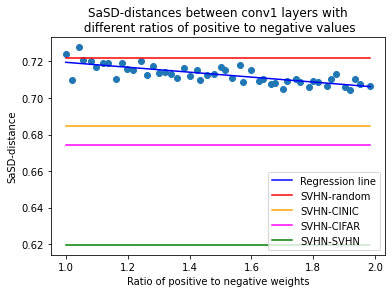

In [14]:
# plot dists_all comparing to other conditions as baselines:
plt.scatter(ratios, dists_all)

#add linear regression line to scatterplot
m, b = np.polyfit(ratios, dists_all, 1)
plt.plot(ratios, m*np.array(ratios)+b, color = "blue", label = "Regression line")

plt.plot([min(ratios), max(ratios)], [mean_dist_mixed_SVHN, mean_dist_mixed_SVHN],color='red', label = "SVHN-random")
plt.plot([min(ratios), max(ratios)], [mean_dist_between_SVHN_CINIC, mean_dist_between_SVHN_CINIC],color='orange', label = "SVHN-CINIC")
plt.plot([min(ratios), max(ratios)], [mean_dist_between_SVHN_CIFAR, mean_dist_between_SVHN_CIFAR],color='magenta', label = "SVHN-CIFAR") 
plt.plot([min(ratios), max(ratios)], [mean_dist_WTs_SVHN, mean_dist_WTs_SVHN],color='green', label = "SVHN-SVHN") 

plt.title("SaSD-distances between conv1 layers with\n different ratios of positive to negative values")
plt.ylabel("SaSD-distance")
plt.xlabel("Ratio of positive to negative weights")
plt.legend(loc = "lower right")
plt.show()

In [15]:
x = ratios.copy()
y = dists_all.copy()
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     68.27
Date:                Fri, 18 Feb 2022   Prob (F-statistic):           8.86e-11
Time:                        23:55:59   Log-Likelihood:                 215.32
No. Observations:                  50   AIC:                            -426.6
Df Residuals:                      48   BIC:                            -422.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7330      0.002    295.531      0.0

### Combinations of weights

In [16]:
# get percentages of each other weight being present when a targeted weight is present
# reshaped such that for each weight that is the strting point, a single vector of 9 values is giving its
# proportions of other weights
SVHN_WTs_pos_pos = pickle.load(open('temp_files/SVHN_WTs_pos_pos', "rb")).reshape((9,9))
SVHN_WTs_neg_neg = pickle.load(open('temp_files/SVHN_WTs_neg_neg', "rb")).reshape((9,9))
SVHN_WTs_neg_pos = pickle.load(open('temp_files/SVHN_WTs_neg_pos', "rb")).reshape((9,9))
SVHN_WTs_pos_neg = pickle.load(open('temp_files/SVHN_WTs_pos_neg', "rb")).reshape((9,9))

In [17]:
# preprocessing the probability masks: For every position with positive/negative weight, the mask 
# should state the probability of the other positions to have a positive/negative weight 
# get copy of all 
pos_pos = SVHN_WTs_pos_pos.copy()
neg_neg = SVHN_WTs_neg_neg.copy()
neg_pos = SVHN_WTs_neg_pos.copy()
pos_neg = SVHN_WTs_pos_neg.copy()

# take away the max in each kernel of pos_pos and neg_neg (as that is the position itself)
pos_pos[pos_pos/np.max(pos_pos, axis = 0) == 1] = 0
neg_neg[neg_neg/np.max(neg_neg, axis = 0) == 1] = 0

# divide by total sum of each kernel to get a total probability of 1 in each kernel
pos_pos = pos_pos/np.sum(pos_pos, axis = 1)[:,np.newaxis]
neg_neg = neg_neg/np.sum(neg_neg, axis = 1)[:,np.newaxis]
pos_neg = pos_neg/np.sum(pos_neg, axis = 1)[:,np.newaxis]
neg_pos = neg_pos/np.sum(neg_pos, axis = 1)[:,np.newaxis]

In [18]:
# prune such that it is accounted for the grouping of same-signed weights and the divergence between 
# different-signed weights

def prune_conv2_combinations(model, comb_importance):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'std' is the standard deviation whcih should be achieved in layer conv1 concerning how many
    weights are left per kernel
    
    Returns:
    pruned_model 
    '''

    ### initialize new model with 0 everywhere that's going to get changed
    pruned_model = conv2_cnn("zeros")  
    
    # only prune first layer
                        
    # shape of w is (height, width, channels, filter), shape of b is (tensors)
    w = model.layers[0].get_weights()[0]
    b = model.layers[0].get_weights()[1] # doesn't need to be changed

    w_new = np.zeros((3,3,3,64))
    
    pruned_weights_perc = 68.619
    
    # magnitude prune all weights normally -> w_intermediate
    w_abs = np.abs(w)
    w_abs[w_abs < np.percentile(w_abs, pruned_weights_perc)] = 0
    w_intermediate = np.where(w_abs == 0, 0, w)
    
    # for each kernel in each filter, leave nr of weights, but reorder such that 
    # probabilities of SVHN-WTs are met
    for nr in range(64):
        for k in range(3):
            # save nr of weights
            nr_weights = np.sum(w_intermediate[:,:,k,nr] != 0)
            
            # if nr_weights is not 0, we need a starting point and already a corresponding mask
            # which will later be reshaped to 3x3
            rand = np.random.randint(9)
            mask = np.zeros(9)
            mask[rand] = 1
            if nr_weights < 2:
                # leave it the way it is, no grouping possible if 0 or 1 weight left
                w_new[:,:,k,nr] = w_intermediate[:,:,k,nr]
            else:
                # look if starting point is 
                # take starting point at rand and add (nr_weights-1) 
                # take probability maps depending on if we chose a starting weight which is positive or negative
                if w[:,:,k,nr].flatten()[rand] < 0:
                    # take neg_neg for all negative values, and neg_pos for all positive
                    # make new prob array with probs for negative values in positions of negative values,
                    # and positive in positive and normalize to sum of 1
                    prob_map = [neg_neg[rand,i] if w[:,:,k,nr].flatten()[i] < 0 else neg_pos[rand,i] for i in range(9)]
                else:
                    prob_map = [pos_pos[rand,i] if w[:,:,k,nr].flatten()[i] > 0 else pos_neg[rand,i] for i in range(9)]
                
                # introduce factor to how much the probability map from house-WTs should be used 
                # and how much just a uniform distribution for all 8 values
                uniform = np.ones((9))
                uniform[rand] = 0
                uniform = uniform/8
                prob_map = np.array(prob_map) * comb_importance + np.array(uniform) * (1-comb_importance)
                prob_map = prob_map/np.sum(prob_map)
                #print(prob_map.reshape((3,3)))
                #print(w[:,:,k,nr])
                #print()
                #print(np.sum(prob_map))

                # choose (nr_weights-1) positions to also not prune
                pos_to_stay = np.random.choice(np.arange(9), size = nr_weights-1, p = prob_map)
                pos_to_stay = np.append(pos_to_stay, rand)
                
                #print(pos_to_stay)
                
                # set w_new and leave weights in positions rand and pos_to_stay
                w_new[:,:,k,nr] = np.array([w[:,:,k,nr].flatten()[i] if i in pos_to_stay else 0 for i in range(9)]).reshape((3,3))
      

    pruned_model.layers[0].set_weights([w_new,b])

        

    return pruned_model

In [19]:
# special prune randomly-initialized networks
# to group weights in the same way as for SVHN-WTs, varying importance of percentages from SVHN-WTs

dists_all = []
comb = []

for comb_imp in np.arange(0,1,0.02):

    net = conv2_cnn()
    net_pruned = prune_conv2_combinations(net, comb_imp)

    # get actual ratio of net
    comb.append(comb_imp)
    #ratios.append(np.sum(np.array(net_pruned.layers[0].get_weights()[0])>0)/np.sum(np.array(net_pruned.layers[0].get_weights()[0])<0))

    dists = []

    # compare to WTs, only first layer        
    for i,ticket in enumerate(WTs_SVHN):
        dists.append(compareLayers(ticket.layers[0].get_weights()[0], net_pruned.layers[0].get_weights()[0]))

    dists_all.append(np.mean(dists))
    #print(np.mean(dists))

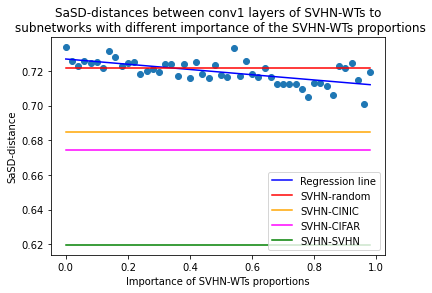

In [20]:
# plot dists_all comparing to other conditions as baselines:
plt.scatter(comb, dists_all)

#add linear regression line to scatterplot 
m, b = np.polyfit(comb, dists_all, 1)
plt.plot(comb, m*np.array(comb)+b, color = "blue", label = "Regression line")

plt.plot([min(comb), max(comb)], [mean_dist_mixed_SVHN, mean_dist_mixed_SVHN],color='red', label = "SVHN-random")
plt.plot([min(comb), max(comb)], [mean_dist_between_SVHN_CINIC, mean_dist_between_SVHN_CINIC],color='orange', label = "SVHN-CINIC")
plt.plot([min(comb), max(comb)], [mean_dist_between_SVHN_CIFAR, mean_dist_between_SVHN_CIFAR],color='magenta', label = "SVHN-CIFAR")
plt.plot([min(comb), max(comb)], [mean_dist_WTs_SVHN, mean_dist_WTs_SVHN],color='green', label = "SVHN-SVHN")

plt.title("SaSD-distances between conv1 layers of SVHN-WTs to\n subnetworks with different importance of the SVHN-WTs proportions")
plt.ylabel("SaSD-distance")
plt.xlabel("Importance of SVHN-WTs proportions")
plt.legend(loc = "lower right")
plt.show()

In [21]:
x = comb.copy()
y = dists_all.copy()
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     34.01
Date:                Sat, 19 Feb 2022   Prob (F-statistic):           4.53e-07
Time:                        00:02:40   Log-Likelihood:                 192.19
No. Observations:                  50   AIC:                            -380.4
Df Residuals:                      48   BIC:                            -376.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7268      0.001    493.279      0.0